In [ ]:
# The purpose of this file is to try ensemble models/classification for Diabetes Endotypes 
# created by Zhongyu Li, May 2024 
# Note: we will only use 6 cohort with HOMA2IR and HOMA2B data

In [37]:
# load libraries
import pandas as pd 
import numpy as np
import os as os

import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV


In [2]:
os. getlogin()

'root'

In [ ]:
#not working, need to figure out why as of 5.12.24 
os. getlogin()

if os.getlogin()=="JVARGH7":
    path_folder = 'C:/Cloud/Emory University/li, zhongyu - Diabetes Endotypes Project (JV and ZL)'
if os.getlogin()=="zhongyuli":
    path_folder = '/Users/zhongyuli/Library/CloudStorage/OneDrive-EmoryUniversity/Diabetes Endotypes Project (JV and ZL)'

# Rename the dataset into analytic sample
analytic_dataset = pd.read_csv(path_folder + '/working/processed/final_dataset.csv')


In [56]:
# first, we will load the data and conduct k means clustering to create the "TRUE labels"
# we will use the HOMA2IR and HOMA2B data to create the labels
# we will use the first 6 cohorts


path = '/Users/zhongyuli/Desktop/python/cluster analysis/dataset/final_dataset.csv'

analytic_dataset = pd.read_csv(path) 

#drop missing values
method3_df = analytic_dataset[analytic_dataset['method3'] == 1]

#select variables 
selected_variables = ['bmi', 'hba1c', 'dmagediag','homa2b','homa2ir','tgl','ldlc','ratio_th','sbp','dbp','hdlc']
#drop missing values in the selected variables
method3_df = method3_df[selected_variables]
method3_df = method3_df.dropna()

#check the data
method3_df.head()



,bmi,hba1c,dmagediag,homa2b,homa2ir,tgl,ldlc,ratio_th,sbp,dbp,hdlc
0,33.37665,6.9,70.0,102.7,2.217295,124,83.0,3.179487,119.2454,65.9166,39.0
1,27.76165,6.5,68.0,113.6,1.945525,101,81.0,1.980392,119.2454,65.0865,51.0
2,30.73822,7.9,51.0,40.6,2.192982,117,131.0,3.342857,162.3397,99.1206,35.0
3,43.56290,6.9,65.0,99.9,2.469136,78,97.0,1.322034,130.2482,70.0671,59.0
4,29.33333,6.5,77.0,104.9,2.577320,158,112.0,2.724138,121.0792,64.2564,58.0


In [57]:
method3_df.shape

(3771, 11)

In [58]:
# check if there are any missing values
method3_df.isnull().sum()
# check variable types
method3_df.dtypes



bmi          float64
hba1c        float64
dmagediag    float64
homa2b       float64
homa2ir      float64
tgl            int64
ldlc         float64
ratio_th     float64
sbp          float64
dbp          float64
hdlc         float64
dtype: object

In [59]:
#run kmeans clustering
#standardize the data
scaler = StandardScaler()
method3_df_scaled = scaler.fit_transform(method3_df)

method3_df_scaled = pd.DataFrame(method3_df_scaled, columns=method3_df.columns)



In [60]:
method3_df_scaled.head()

,bmi,hba1c,dmagediag,homa2b,homa2ir,tgl,ldlc,ratio_th,sbp,dbp,hdlc
0,-0.032257,0.300357,0.645757,-0.220785,-0.458673,-0.242366,-0.774925,-0.090932,-0.326612,-0.636184,-0.668157
1,-0.832829,-0.048265,0.489212,-0.091397,-0.560173,-0.512939,-0.830633,-0.511314,-0.326612,-0.692720,0.252415
2,-0.408438,1.171911,-0.841426,-0.957942,-0.467753,-0.324714,0.562068,-0.033657,1.987405,1.625245,-0.975014
3,1.420073,0.300357,0.254393,-0.254023,-0.364617,-0.783512,-0.384969,-0.742123,0.264201,-0.353505,0.866129
4,-0.608743,-0.048265,1.193667,-0.194670,-0.324213,0.157612,0.032841,-0.250570,-0.228143,-0.749256,0.789414


In [61]:
# run kmeans and get cluster labels from the five variable method (method 3)
kmeans = KMeans(
    init="random", n_clusters=4, n_init=10, max_iter=300, random_state=57
)

# select five variables to cluster
var_m3 = ['bmi', 'hba1c', 'dmagediag','homa2b','homa2ir']
cluster_m3 = method3_df_scaled[var_m3]

kmeans = KMeans(init="random", n_clusters=4, n_init=10, max_iter=300, random_state=57)
kmeans.fit(cluster_m3)

KMeans(init='random', n_clusters=4, n_init=10, random_state=57)

In [62]:
# summarize the cluster labels 
method3_df_cluster = method3_df
method3_df_cluster['cluster'] = kmeans.labels_
method3_df_cluster['cluster'].value_counts()


cluster
0    1766
1    1481
3     290
2     234
Name: count, dtype: int64

In [63]:
method3_df_cluster.groupby('cluster').mean()

,bmi,hba1c,dmagediag,homa2b,homa2ir,tgl,ldlc,ratio_th,sbp,dbp,hdlc
cluster,,,,,,,,,,,
0,29.624151,6.269762,70.743322,86.821631,2.107629,133.261608,106.051076,2.960120,127.687002,70.621010,50.251076
1,38.086894,6.384085,51.314338,133.598042,3.866042,155.496286,117.407562,3.903651,122.223853,80.640832,44.889804
2,34.958178,9.900000,55.524927,52.536325,3.077110,149.948718,116.474359,3.587225,126.418088,80.898582,47.239316
3,33.839130,6.470690,65.299499,323.935517,9.741132,153.713793,101.668966,3.860884,125.934720,71.448641,47.013793


In [64]:
# remane the cluster labels
method3_df_cluster['cluster'] = method3_df['cluster'].replace({0: 'MARD', 1: 'MOD', 2: 'SIDD', 3: 'SIRD'})
method3_df_cluster['cluster'].value_counts()
#summarize variables by cluster
method3_df_cluster.groupby('cluster').mean()

,bmi,hba1c,dmagediag,homa2b,homa2ir,tgl,ldlc,ratio_th,sbp,dbp,hdlc
cluster,,,,,,,,,,,
MARD,29.624151,6.269762,70.743322,86.821631,2.107629,133.261608,106.051076,2.960120,127.687002,70.621010,50.251076
MOD,38.086894,6.384085,51.314338,133.598042,3.866042,155.496286,117.407562,3.903651,122.223853,80.640832,44.889804
SIDD,34.958178,9.900000,55.524927,52.536325,3.077110,149.948718,116.474359,3.587225,126.418088,80.898582,47.239316
SIRD,33.839130,6.470690,65.299499,323.935517,9.741132,153.713793,101.668966,3.860884,125.934720,71.448641,47.013793


In [15]:
# run random forest model
# select the variables
var_m4 = ['bmi', 'hba1c', 'dmagediag','tgl','ldlc','ratio_th','sbp','dbp','hdlc']
X = method3_df_cluster[var_m4]
y = method3_df_cluster['cluster']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)

# run random forest model
rf = RandomForestClassifier(random_state=57, class_weight='balanced') 
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# check the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8609271523178808


In [16]:
# obtain the accuracy of the model by each cluster 
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        MARD       0.88      0.92      0.90       336
         MOD       0.84      0.93      0.89       322
        SIDD       0.85      0.91      0.88        45
        SIRD       0.00      0.00      0.00        52

    accuracy                           0.86       755
   macro avg       0.64      0.69      0.67       755
weighted avg       0.80      0.86      0.83       755



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [17]:
# Model tuning
# define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_samples': [0.5, 0.7, 0.9]
}

# run grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)






Fitting 3 folds for each of 1296 candidates, totalling 3888 fits
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, max_samples=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, max_samples=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, max_samples=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, max_samples=0.5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, max_samples=0.5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced, criterion=gini, max_dep

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END class_weight=balanced_subsample, criterion=gini, max_depth=20, max_features=sqrt, max_samples=0.7, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END class_weight=balanced_subsample, criterion=gini, max_depth=20, max_features=sqrt, max_samples=0.7, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END class_weight=balanced_subsample, criterion=gini, max_depth=20, max_features=sqrt, max_samples=0.7, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END class_weight=balanced_subsample, criterion=gini, max_depth=20, max_features=sqrt, max_samples=0.7, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END class_weight=balanced_subsample, criterion=gini, max_depth=20, max_features=sqrt, max_samples=0.7, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END class_weight=balanced_subsample, criterion=gini, max_depth=

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=57),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'max_samples': [0.5, 0.7, 0.9],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             verbose=2)

In [18]:
# summarize the results 
grid_search.best_score_
# get the accuracy of the best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# get the best parameters
grid_search.best_params_



Accuracy: 0.856953642384106


{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

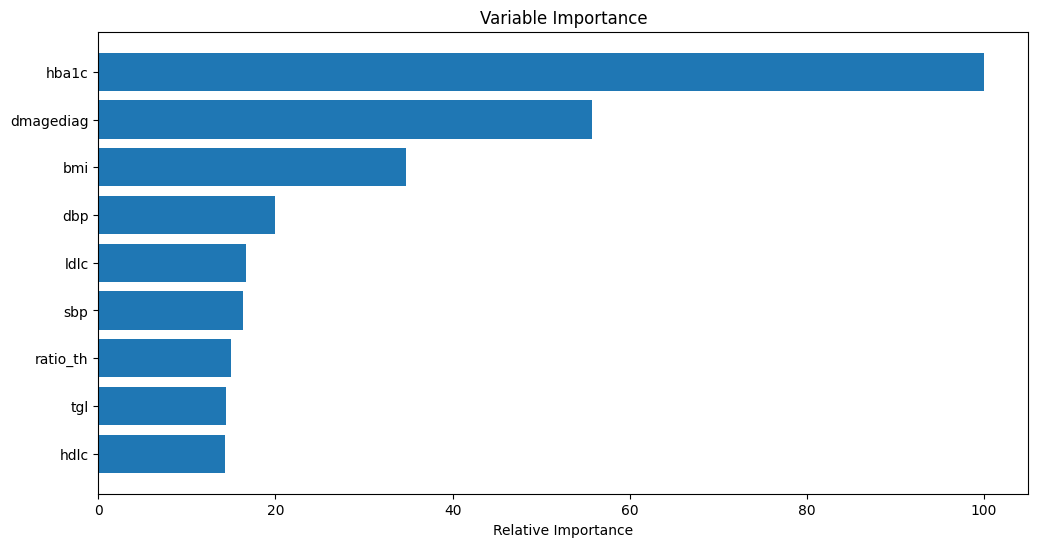

In [19]:
# get the feature importance
feature_importance = best_rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


The contribution of age, hba1c, and bmi to the classficiation results is very substantial compared with other six variables. This may explain the misclassfication of SIRD to MOD and MARD. 

In [20]:
# get the classification report 
print(classification_report(y_test, y_pred))
# improvement after tuning the model was slightly improvded 

              precision    recall  f1-score   support

        MARD       0.87      0.92      0.89       336
         MOD       0.85      0.92      0.88       322
        SIDD       0.85      0.91      0.88        45
        SIRD       0.00      0.00      0.00        52

    accuracy                           0.86       755
   macro avg       0.64      0.69      0.66       755
weighted avg       0.80      0.86      0.83       755



### Summary of the RF model after tunning 
1. precision: true positive/(true positive + false positive), very low for SIRD 
2. Recall: the ability of a model to find all actual positive cases, very low for SIRD, the model failed to find most of the actual SIRD 
3. F1 score: the weighted average of the precison and recall, taking both false positives and false negatives into account. very low for SIRD
4. The number of actual occurences of the class in the dataset. 
5. macro avg: average of precision, recall, and F1 score across all classes, label imbalance not taken into account 
6. Weight avg: label imbalance was taken into account by weighting the score of each class by the number of true instances. Macro vs. Weighted Metrics: The weighted averages are higher than the macro averages, indicating that the model performs well on larger classes but struggles with smaller/more complex classes. Addressing the balance and tuning based on class-specific metrics can be beneficial.

In [21]:
# describe the inccorectly classified samples
incorrect = y_test != y_pred
incorrect_samples = X_test[incorrect]
incorrect_samples['true_label'] = y_test[incorrect]
incorrect_samples['predicted_label'] = y_pred[incorrect]
incorrect_samples.head()

# summarize the incorrectly classified samples and compare the true and predicted labels

incorrect_samples.groupby(['true_label', 'predicted_label']).mean()





/var/folders/mw/svm2x9qn5fx658rhfzs94mxh0000gn/T/ipykernel_19626/3533132690.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_samples['true_label'] = y_test[incorrect]
/var/folders/mw/svm2x9qn5fx658rhfzs94mxh0000gn/T/ipykernel_19626/3533132690.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_samples['predicted_label'] = y_pred[incorrect]


bmi     hba1c  dmagediag         tgl  \
true_label predicted_label                                               
MARD       MOD              31.617474  6.160000  55.742137  185.880000   
           SIDD             35.543170  8.400000  75.000000  133.000000   
           SIRD             33.642990  6.700000  61.000000  116.000000   
MOD        MARD             35.355849  6.109524  64.512590  155.666667   
           SIDD             42.682385  8.200000  46.745890  179.000000   
SIDD       MOD              31.314525  7.925000  48.750000  113.750000   
SIRD       MARD             31.539325  6.457692  69.959115  126.115385   
           MOD              38.856982  6.362500  54.224200  230.833333   
           SIDD             32.401840  8.900000  56.000000  175.500000   

                                  ldlc  ratio_th         sbp        dbp  \
true_label predicted_label                                                
MARD       MOD              134.680000  4.025007  115.813334  84.133333   
           SIDD             157.000000  3.022727  119.000000  76.000000   
           SIRD              91.000000  2.416667  114.000000  66.000000   
MOD        MARD             106.761905  3.343635  125.186200  75.782513   
           SIDD             109.500000  4.166608  127.019100  80.770008   
SIDD       MOD               87.500000  2.922835  126.668257  76.613483   
SIRD       MARD              99.884615  2.893551  128.256411  69.025642   
           MOD              105.583333  6.975685  116.472223  76.861111   
           SIDD             121.500000  4.410024  125.498985  77.527085   

                                 hdlc  
true_label predicted_label             
MARD       MOD              48.600000  
           SIDD             44.000000  
           SIRD             48.000000  
MOD        MARD             47.523810  
           SIDD             43.500000  
SIDD       MOD              44.000000  
SIRD       MARD             48.423077  
           MOD              40.958333  
           SIDD             41.000000

In [22]:
incorrect_samples.groupby(['true_label', 'predicted_label']).size()

true_label  predicted_label
MARD        MOD                25
            SIDD                1
            SIRD                1
MOD         MARD               21
            SIDD                4
SIDD        MOD                 4
SIRD        MARD               26
            MOD                24
            SIDD                2
dtype: int64

In [23]:
# summarize the both corrent and incorrect samples
X_test['true_label'] = y_test
X_test['predicted_label'] = y_pred
X_test['correct'] = X_test['true_label'] == X_test['predicted_label']
X_test.groupby(['true_label', 'predicted_label', 'correct']).mean()


bmi     hba1c  dmagediag  \
true_label predicted_label correct                                   
MARD       MARD            True     29.259782  6.276699  71.262792   
           MOD             False    31.617474  6.160000  55.742137   
           SIDD            False    35.543170  8.400000  75.000000   
           SIRD            False    33.642990  6.700000  61.000000   
MOD        MARD            False    35.355849  6.109524  64.512590   
           MOD             True     38.434314  6.395623  50.961358   
           SIDD            False    42.682385  8.200000  46.745890   
SIDD       MOD             False    31.314525  7.925000  48.750000   
           SIDD            True     34.960044  9.943902  59.427264   
SIRD       MARD            False    31.539325  6.457692  69.959115   
           MOD             False    38.856982  6.362500  54.224200   
           SIDD            False    32.401840  8.900000  56.000000   

                                           tgl        ldlc  ratio_th  \
true_label predicted_label correct                                     
MARD       MARD            True     130.333333  106.282848  2.859569   
           MOD             False    185.880000  134.680000  4.025007   
           SIDD            False    133.000000  157.000000  3.022727   
           SIRD            False    116.000000   91.000000  2.416667   
MOD        MARD            False    155.666667  106.761905  3.343635   
           MOD             True     152.585859  119.225589  3.776648   
           SIDD            False    179.000000  109.500000  4.166608   
SIDD       MOD             False    113.750000   87.500000  2.922835   
           SIDD            True     157.365854  121.365854  3.685448   
SIRD       MARD            False    126.115385   99.884615  2.893551   
           MOD             False    230.833333  105.583333  6.975685   
           SIDD            False    175.500000  121.500000  4.410024   

                                           sbp        dbp       hdlc  
true_label predicted_label correct                                    
MARD       MARD            True     126.671491  69.809324  51.168932  
           MOD             False    115.813334  84.133333  48.600000  
           SIDD            False    119.000000  76.000000  44.000000  
           SIRD            False    114.000000  66.000000  48.000000  
MOD        MARD            False    125.186200  75.782513  47.523810  
           MOD             True     122.658353  81.646016  44.680135  
           SIDD            False    127.019100  80.770008  43.500000  
SIDD       MOD             False    126.668257  76.613483  44.000000  
           SIDD            True     126.808116  79.598417  46.097561  
SIRD       MARD            False    128.256411  69.025642  48.423077  
           MOD             False    116.472223  76.861111  40.958333  
           SIDD            False    125.498985  77.527085  41.000000

In [24]:
X_test.groupby(['true_label', 'predicted_label', 'correct']).size()

true_label  predicted_label  correct
MARD        MARD             True       309
            MOD              False       25
            SIDD             False        1
            SIRD             False        1
MOD         MARD             False       21
            MOD              True       297
            SIDD             False        4
SIDD        MOD              False        4
            SIDD             True        41
SIRD        MARD             False       26
            MOD              False       24
            SIDD             False        2
dtype: int64

In [28]:
from sklearn.metrics import classification_report

# Calculate the classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Print the report to see its structure
print(report)

# Extract the metrics
sensitivity = report['1']['recall'] if '1' in report else None
specificity = report['0']['recall'] if '0' in report else None
ppv = report['1']['precision'] if '1' in report else None
npv = report['0']['precision'] if '0' in report else None

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Positive Predictive Value: {ppv}")
print(f"Negative Predictive Value: {npv}")


{'MARD': {'precision': 0.8679775280898876, 'recall': 0.9196428571428571, 'f1-score': 0.8930635838150289, 'support': 336.0}, 'MOD': {'precision': 0.8485714285714285, 'recall': 0.922360248447205, 'f1-score': 0.8839285714285714, 'support': 322.0}, 'SIDD': {'precision': 0.8541666666666666, 'recall': 0.9111111111111111, 'f1-score': 0.8817204301075269, 'support': 45.0}, 'SIRD': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 52.0}, 'accuracy': 0.856953642384106, 'macro avg': {'precision': 0.6426789058319957, 'recall': 0.6882785541752933, 'f1-score': 0.6646781463377818, 'support': 755.0}, 'weighted avg': {'precision': 0.7990966217724533, 'recall': 0.856953642384106, 'f1-score': 0.8269824947240906, 'support': 755.0}}
Sensitivity: None
Specificity: None
Positive Predictive Value: None
Negative Predictive Value: None


### Try Resampling 

In [50]:
# pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)


In [66]:
smote = SMOTE(random_state=57)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)



In [67]:
rf = RandomForestClassifier(n_estimators=200, max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, criterion='entropy', max_samples=0.7, random_state=57)

rf.fit(X_resampled, y_resampled)


RandomForestClassifier(criterion='entropy', max_depth=20, max_samples=0.7,
                       n_estimators=200, random_state=57)

In [69]:
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8081123244929798
              precision    recall  f1-score   support

        MARD       0.88      0.86      0.87       301
         MOD       0.88      0.86      0.87       249
        SIDD       0.87      0.96      0.92        28
        SIRD       0.24      0.27      0.25        63

    accuracy                           0.81       641
   macro avg       0.72      0.74      0.73       641
weighted avg       0.82      0.81      0.81       641



In [ ]:
# run grid search
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
# grid_search.fit(X_resampled, y_resampled)

In [71]:
# summarize the results
grid_search.best_score_
# get the accuracy of the best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# get the best parameters
grid_search.best_params_


Accuracy: 0.8081123244929798


{'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_depth': 30,
 'max_features': 'sqrt',
 'max_samples': 0.9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

#### No improvements after resampling 

### Try combine RF and Gradient Boosting Machines (GBMs)

In [75]:
# FR and GBM models
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)

# Random Forest model, use the best parameters from the grid search
# rf = RandomForestClassifier(n_estimators=200, max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, criterion='entropy', class_weight='balanced_subsample', max_samples=0.7, random_state=57)

estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, criterion='entropy', class_weight='balanced_subsample', max_samples=0.7, random_state=57)),
    ('gbm', GradientBoostingClassifier(n_estimators=100, random_state=57))
]

# Create the stacking model
stack_model = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(n_estimators=200, random_state=57), cv=5)

# Train the stacking model
stack_model.fit(X_train, y_train)

# Evaluate the model
score = stack_model.score(X_test, y_test)
print(f"Accuracy of stacked model: {score}")

Accuracy of stacked model: 0.84399375975039


In [76]:
# get the classification report
y_pred = stack_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        MARD       0.83      0.96      0.89       301
         MOD       0.86      0.90      0.88       249
        SIDD       0.87      0.96      0.92        28
        SIRD       0.50      0.02      0.03        63

    accuracy                           0.84       641
   macro avg       0.77      0.71      0.68       641
weighted avg       0.81      0.84      0.80       641



#### RF + GBM does not appear to improve the predictions either 

#### Now TRY GMM

Train Silhouette Score: 0.07364160730651179
Test Silhouette Score: 0.07149943770473267
Adjusted Rand Index: 0.06367489854286093


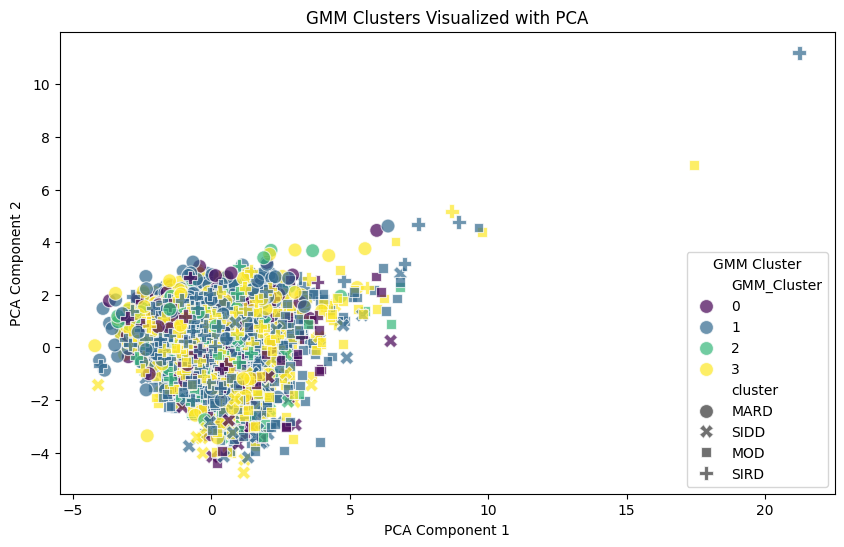


Summary Report
Model: Gaussian Mixture Model
Train Silhouette Score: 0.07364160730651179
Test Silhouette Score: 0.07149943770473267
Adjusted Rand Index: 0.06367489854286093


In [53]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, accuracy_score,adjusted_rand_score


# select the variables
var_m4 = ['bmi', 'hba1c', 'dmagediag','tgl','ldlc','ratio_th','sbp','dbp','hdlc']
X = method3_df_cluster[var_m4]
y = method3_df_cluster['cluster']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=57)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the GMM model
gmm = GaussianMixture(n_components=4, random_state=57)
gmm.fit(X_train_scaled)

# Predict the probabilities and labels
y_train_pred = gmm.predict(X_train_scaled)
y_test_pred = gmm.predict(X_test_scaled)
# Evaluate the model
train_silhouette = silhouette_score(X_train_scaled, y_train_pred)
test_silhouette = silhouette_score(X_test_scaled, y_test_pred)
ari = adjusted_rand_score(y_test, y_test_pred)

print(f'Train Silhouette Score: {train_silhouette}')
print(f'Test Silhouette Score: {test_silhouette}')
print(f'Adjusted Rand Index: {ari}')

# Append predicted labels to the original dataset
method3_df_cluster_gmm = method3_df_cluster
method3_df_cluster_gmm['GMM_Cluster'] = np.concatenate([y_train_pred, y_test_pred])

# Visualize clusters using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaler.fit_transform(X))

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=method3_df_cluster_gmm['GMM_Cluster'], palette='viridis', style=method3_df_cluster_gmm['cluster'], s=100, alpha=0.7)
plt.title('GMM Clusters Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='GMM Cluster')
plt.show()

# Create a summary report
report = {
    'Model': 'Gaussian Mixture Model',
    'Train Silhouette Score': train_silhouette,
    'Test Silhouette Score': test_silhouette,
    'Adjusted Rand Index': ari
}

print("\nSummary Report")
for key, value in report.items():
    print(f'{key}: {value}')

##### GMM does not appear to work well.

Silhouette Score: 0.050650149253923894


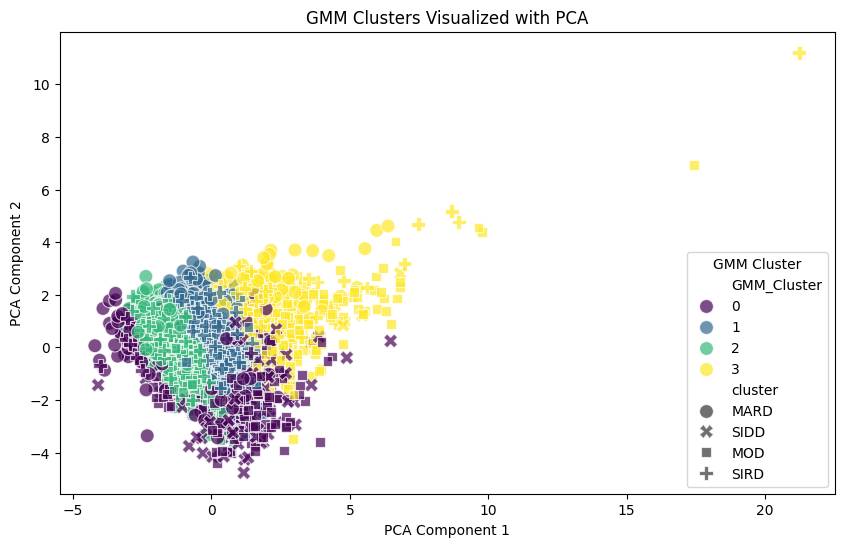


Summary Report
Model: Gaussian Mixture Model
Silhouette Score: 0.050650149253923894


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Assuming method3_df_cluster is your DataFrame
# Select the variables
var_m4 = ['bmi', 'hba1c', 'dmagediag', 'tgl', 'ldlc', 'ratio_th', 'sbp', 'dbp', 'hdlc']
X = method3_df_cluster[var_m4]

# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the GMM model
gmm = GaussianMixture(n_components=4, random_state=57)
gmm.fit(X_scaled)

# Predict the cluster labels
y_pred = gmm.predict(X_scaled)

# Evaluate the model
silhouette_avg = silhouette_score(X_scaled, y_pred)

print(f'Silhouette Score: {silhouette_avg}')

# Append predicted labels to the original dataset
method3_df_cluster_gmm = method3_df_cluster
method3_df_cluster_gmm['GMM_Cluster'] = y_pred

# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=method3_df_cluster_gmm['GMM_Cluster'], palette='viridis', style=method3_df_cluster_gmm['cluster'], s=100, alpha=0.7)
plt.title('GMM Clusters Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='GMM Cluster')
plt.show()

# Create a summary report
report = {
    'Model': 'Gaussian Mixture Model',
    'Silhouette Score': silhouette_avg
}

print("\nSummary Report")
for key, value in report.items():
    print(f'{key}: {value}')

In [67]:
# summarize the clusters from GMM
# drop the cluster column
method3_df_cluster_gmm = method3_df_cluster_gmm.drop('cluster', axis=1)
# summarize the clusters
method3_df_cluster_gmm.groupby('GMM_Cluster').mean()


,bmi,hba1c,dmagediag,homa2b,homa2ir,tgl,ldlc,ratio_th,sbp,dbp,hdlc
GMM_Cluster,,,,,,,,,,,
0,33.180121,8.005450,57.825339,86.198341,2.825322,146.374408,114.688626,3.039301,114.921476,90.166303,57.684360
1,33.837613,6.413302,62.231318,131.543850,3.760972,148.182487,112.768316,3.506197,126.464677,73.557746,42.444184
2,33.096452,6.350467,63.850339,113.950668,2.943765,95.116469,110.670846,1.716545,127.185200,72.275627,55.986424
3,34.612681,6.311485,57.996685,139.900396,4.367840,264.607921,102.220792,8.170667,125.699020,75.794129,32.879604
